In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define data path
data_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/train_data"
os.listdir(data_dir)
classes = ['tomato', 'cherry', 'strawberry']

In [3]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np

In [4]:
from PIL import UnidentifiedImageError

valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Check if the file has a valid image extension
        if os.path.splitext(img_file)[1].lower() in valid_image_extensions:
            try:
                image = Image.open(img_path)
                #print(image.size)  # Print image dimensions
                # image.show()  # Display the image (optional)
            except UnidentifiedImageError:
                print(f"Cannot identify image file: {img_path}")
        else:
            print(f"Skipping non-image file: {img_path}")

In [5]:
from PIL import Image

target_size = (300, 300)

def resize_images(data_dir, target_size):
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image = Image.open(img_path)
            if image.size != target_size:
                image = image.resize(target_size)
                image.save(img_path)  # Overwrite the image with resized version

resize_images(data_dir, target_size)

In [6]:
dimensions = []
color_modes = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        image = Image.open(img_path)
        dimensions.append(image.size)
        color_modes.append(image.mode)

# Unique dimensions and color modes
print("Unique dimensions:", set(dimensions))
print("Unique color modes:", set(color_modes))

Unique dimensions: {(300, 300)}
Unique color modes: {'L', 'RGB'}


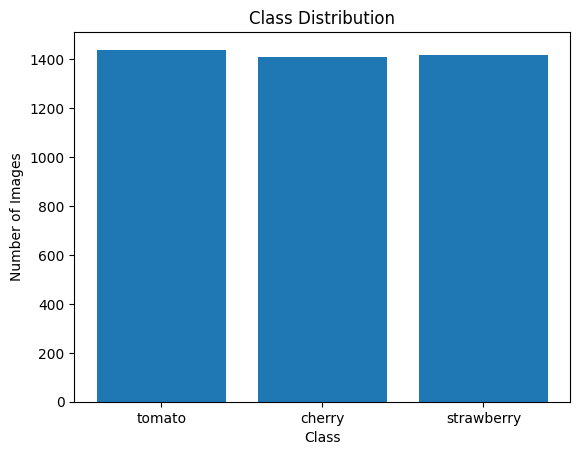

In [7]:
import matplotlib.pyplot as plt

class_counts = {}

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Bar chart to visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

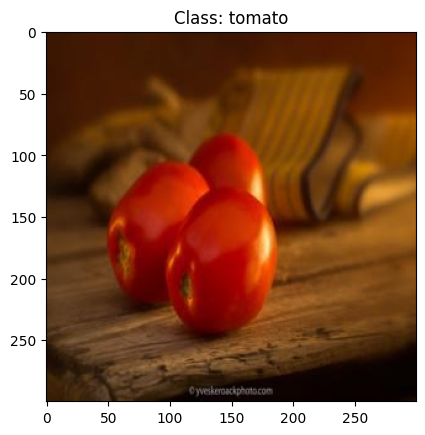

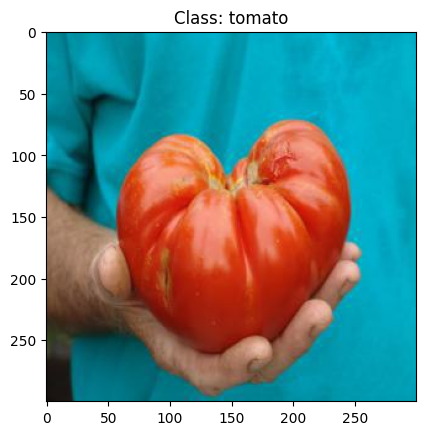

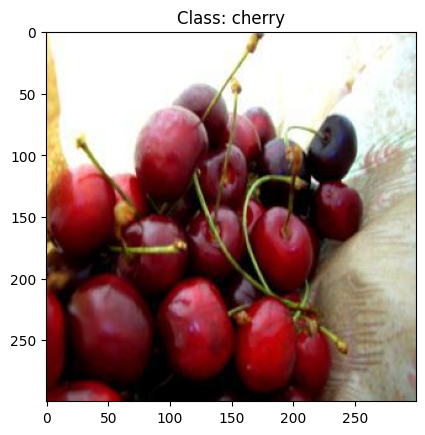

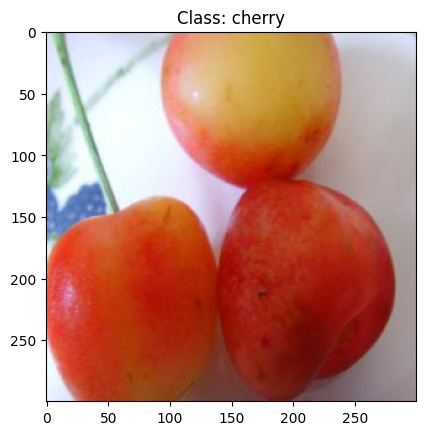

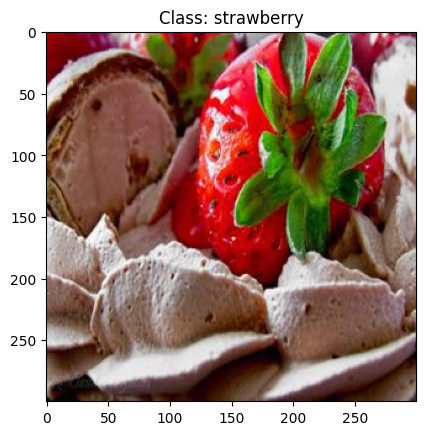

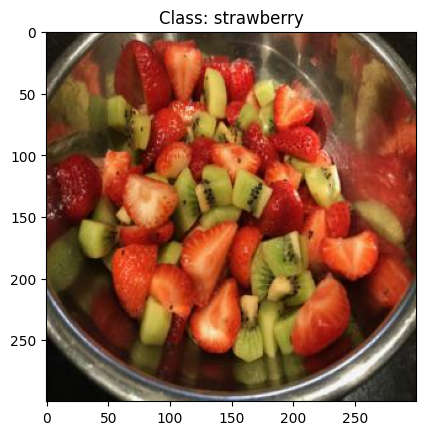

In [8]:
import random

def display_random_images(data_dir, classes, num_samples=2):
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        img_files = os.listdir(class_path)
        random_images = random.sample(img_files, num_samples)

        for img_file in random_images:
            img_path = os.path.join(class_path, img_file)
            image = Image.open(img_path)
            plt.imshow(image)
            plt.title(f'Class: {class_name}')
            plt.show()

display_random_images(data_dir, classes)

In [9]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np

In [10]:
# Define image size
IMAGE_SIZE = 300


# Define a simple transform to convert images to tensors
simple_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load the dataset with simple transform
temp_dataset = datasets.ImageFolder(root=data_dir, transform=simple_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=2)

# Calculate mean and std
mean = 0.0
std = 0.0
total_images_count = 0
for images, _ in temp_loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")


# Transformation for training data: includes data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),            # Horizontal flipping
    transforms.RandomRotation(20),                # Random rotation
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Random cropping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transformation for validation/test data: no augmentation
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Load the dataset with ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split the dataset into training and validation sets (e.g., 80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply test_transforms to validation dataset
# To do this, we need to overwrite the transform for val_dataset
val_dataset.dataset.transform = test_transforms

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Calculated Mean: tensor([0.5469, 0.4078, 0.3354])
Calculated Std: tensor([0.2291, 0.2381, 0.2302])


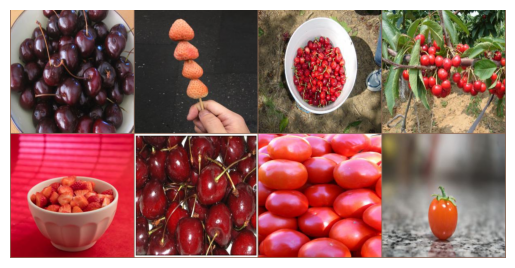

In [11]:
import torchvision

# Function to denormalize and display images
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8], nrow=4))

In [12]:
def is_blurry(image_path, threshold=100):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.filter(ImageFilter.FIND_EDGES)
    img_np = np.array(image)
    variance = np.var(img_np)
    return variance < threshold

def remove_blurry_images(directory, threshold=100):
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                if is_blurry(img_path, threshold):
                    print(f"Removing blurry image: {img_file}")
                    os.remove(img_path)
            except Exception as e:
                print(f"Error processing {img_file}: {e}")

# Apply the function
remove_blurry_images(data_dir, threshold=100)

In [13]:
def remove_corrupted_images(directory):
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {img_file}")
                os.remove(img_path)

# Apply the function
remove_corrupted_images(data_dir)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Define the layers of the MLP
        self.fc1 = nn.Linear(300 * 300 * 3, 512)  # Input layer (300x300 RGB image flattened)
        self.fc2 = nn.Linear(512, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 128)  # Hidden layer 2
        self.fc4 = nn.Linear(128, 3)    # Output layer (3 classes: tomato, cherry, strawberry)

    def forward(self, x):
        x = x.view(-1, 300 * 300 * 3)  # Flatten the input image
        x = F.relu(self.fc1(x))  # ReLU activation for hidden layer 1
        x = F.relu(self.fc2(x))  # ReLU activation for hidden layer 2
        x = F.relu(self.fc3(x))  # ReLU activation for hidden layer 3
        x = self.fc4(x)          # Output layer (no activation, since we'll apply softmax with CrossEntropyLoss)
        return x

In [16]:
# Define transformations (including resizing and normalization)
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300
    transforms.ToTensor(),  # Convert image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Load dataset (assuming you have already defined `data_dir`)
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Initialize the MLP model
model = MLP()

# Define the loss function (Cross-Entropy Loss) and optimizer (Stochastic Gradient Descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            # Track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

In [19]:
def validate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.2f}%')

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train(model, train_loader, criterion, optimizer, num_epochs=1)
    validate(model, val_loader, criterion)
    print('-' * 30)

Epoch 1/5
Epoch [1/1], Loss: 1.1165, Accuracy: 41.25%
Validation Loss: 1.0803, Accuracy: 45.13%
------------------------------
Epoch 2/5
Epoch [1/1], Loss: 1.0161, Accuracy: 49.31%
Validation Loss: 1.0456, Accuracy: 45.37%
------------------------------
Epoch 3/5
Epoch [1/1], Loss: 0.9641, Accuracy: 52.77%
Validation Loss: 1.0149, Accuracy: 47.83%
------------------------------
Epoch 4/5
Epoch [1/1], Loss: 0.8845, Accuracy: 59.57%
Validation Loss: 1.0616, Accuracy: 47.83%
------------------------------
Epoch 5/5
Epoch [1/1], Loss: 0.8775, Accuracy: 58.87%
Validation Loss: 1.0651, Accuracy: 50.53%
------------------------------


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Convolutional Layer: 3 input channels (RGB), 32 output channels (filters), 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling (2x2)

        # Second Convolutional Layer: 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after conv2

        # Third Convolutional Layer: 64 input channels, 128 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization after conv3

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 37 * 37, 256)  # Assuming input image size 300x300
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)  # Output layer (3 classes)

        # Dropout layers to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and max-pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the image from 128 x 37 x 37 to a vector
        x = x.view(-1, 128 * 37 * 37)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer (no activation, since we'll use CrossEntropyLoss)
        x = self.fc3(x)
        return x

In [23]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300
    transforms.ToTensor(),  # Convert image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Initialize the CNN model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Using Adam optimizer


In [25]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

In [26]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.2f}%')

In [29]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train(model, train_loader, criterion, optimizer, num_epochs=1)
    validate(model, val_loader, criterion)
    print('-' * 30)

Epoch 1/10
Epoch [1/1], Loss: 0.7843, Accuracy: 65.82%
Validation Loss: 0.7396, Accuracy: 71.63%
------------------------------
Epoch 2/10
Epoch [1/1], Loss: 0.7560, Accuracy: 66.34%
Validation Loss: 0.7677, Accuracy: 68.46%
------------------------------
Epoch 3/10
Epoch [1/1], Loss: 0.7349, Accuracy: 66.90%
Validation Loss: 0.7252, Accuracy: 69.87%
------------------------------
Epoch 4/10
Epoch [1/1], Loss: 0.7381, Accuracy: 66.67%
Validation Loss: 0.7291, Accuracy: 71.04%
------------------------------
Epoch 5/10
Epoch [1/1], Loss: 0.6902, Accuracy: 68.75%
Validation Loss: 0.6824, Accuracy: 71.75%
------------------------------
Epoch 6/10
Epoch [1/1], Loss: 0.6622, Accuracy: 69.92%
Validation Loss: 0.7230, Accuracy: 69.28%
------------------------------
Epoch 7/10
Epoch [1/1], Loss: 0.6329, Accuracy: 72.35%
Validation Loss: 0.7290, Accuracy: 71.40%
------------------------------
Epoch 8/10
Epoch [1/1], Loss: 0.5992, Accuracy: 74.44%
Validation Loss: 0.6934, Accuracy: 70.93%
-------

In [28]:
import torch
# Save the trained model
torch.save(model.state_dict(), 'model.pth')

# Load the model for testing
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode


<ipython-input-28-6e0d0bd2c1b9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=175232, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)